In [1]:
import os, time, datetime, json, itertools

import numpy as np
import numpy.random as npr
import scipy.stats as scs
import pandas as pd
import cvxpy as cp

from math import ceil, floor
from itertools import product
from dataclasses import dataclass, fields

npr.seed(42)
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# Paths
FILEPATH_FIG = "fig/"
FILEPATH_RES = "results/"

In [3]:
class DotDict(dict):
    '''dot.notation access to dictionary attributes'''
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
'''
GLOBALS
'''
# Time and control horizon 
T = 3
H = 24
TOTAL_HOURS = 24*T + H
TOTAL_DAYS  = T + ceil(H // 24)

# ADALM settings
ITERS = 30
RHO_S = 1
RHO_C = 15
CHI   = 0.49

# Initial number of agents
INIT_CEVS = 5
INIT_TEVS = 5
INIT_PROSUMERS = 5

# Average number of new agents per hour
AVG_NUM_NEW_TEVS = 0.4
AVG_NUM_NEW_CEVS = 0.8

# Average and std parking/charging times
MAX_AVG_PARK   = 72 # (hours)
MAX_STD_PARK   = 24 # (hours)
MAX_AVG_CHARGE = 24 # (hours)
MAX_STD_CHARGE = 24 # (hours)

# Battery parameters
ZETA = 1e-2 
NI   = 1e-2
ETA_UP = 0.99
ETA_DW = 1.01
ALPHA  = 1-1e-2

# Maximum fraction of initial battery
CEVS_BATT_INIT_FR = 0.2
TEVS_BATT_INIT_FR = 1

# Flow variables limits
MAX_R  = 100
MAX_A  = 10
MAX_PQ = 10
MAX_DB = 10

# Prices from "Enel Bioraria" fees table
# (https://www.enel.it/it/luce-e-gas/luce/offerte/e-light-bioraria)
BLUE    = 0.13599
ORANGE  = 0.15803
EPSILON = 0.7
SELL = np.hstack([BLUE*np.ones((1,8)), ORANGE*np.ones((1,11)), BLUE*np.ones((1,5))])
BUY  = EPSILON * SELL

# Demand, generation and battery data
EV_CHARGE_SPEED = np.load("data/ev_charge_speed.npy")
EV_BATTERY      = np.load("data/ev_capacity.npy")
EV_RANGE        = np.load("data/ev_range.npy")
DEMAND          = np.load("data/energy_demand.npy")
GENERATION      = 0.7*np.load("data/energy_generation.npy")

# Variables and multipleirs names
VARS_PROSUMERS_TEVS = ("d_up", "d_dw", "u")
VARS_PROSUMERS_RET  = ("a_up", "a_dw")
VARS_PROSUMERS_CEVS = ("p",)
VARS_TEVS_PROSUMERS = ("b_up", "b_dw", "w")
VARS_CEVS_PROSUMERS = ("q",)
VARS_CEVS_RET       = ("r",)
MLTS_PROSUMER_TEVS  = ("phi_up", "phi_dw", "theta")
MLTS_PROSUMER_CEVS  = ("psi",)

# Agent groups names
HIST = ("hist_pros", "hist_cevs", "hist_tevs", "hist_departed_evs")

'''
GENERATORS
'''
new_id = itertools.count()

def num_new_evs(avg_num_new_evs):
    return floor(npr.poisson(avg_num_new_evs))

def sample_energy_curve(curve_name):
    curve            = globals()[curve_name]
    n_sample, n_cols = curve.shape
    max_data         = np.max(curve)
    random_index     = npr.randint(0,n_sample)
    sampled_curve    = curve[random_index] 
    random_noise     = max_data*npr.rand(n_cols*TOTAL_DAYS)
    return np.tile(sampled_curve, TOTAL_DAYS) + random_noise

In [7]:
@dataclass
class Data:   
    '''Dynamic data''' 
    # Current time 
    t = 0

    # Agents groups
    pros, tevs, cevs, departed_evs = dict(), dict(), dict(), dict()
    
    # History
    hist_pros, hist_tevs, hist_cevs, hist_departed_evs = [], [], [], []
    
    def clock():
        Data.t += 1
        for agent in (Data.pros | Data.tevs | Data.cevs).values():
            agent.t_curr = Data.t
        
    def id2idx(ID, agents):
        return list(agents.keys()).index(ID)
    
    def C(): return len(Data.cevs)

    def S(): return len(Data.tevs)
    
    def P(): return len(Data.pros)
    
    def hist_C(): return len(Data.hist_cevs)

    def hist_S(): return len(Data.hist_tevs)
    
    def hist_P(): return len(Data.hist_pros)

# Agent classes

In [6]:
class Agent():
    '''Generic Agent class'''
    DISCARDED_FROM_SAVE = ("distr", "prob", "constraints")
    
    def __init__(self, ID):
        self.ID      = ID
        self.t_init  = Data.t   
        self.t_curr  = Data.t # For seeing when the agent leaves
        self._active = True
        self.distr   = scs.uniform(0, 1)
        
    @property
    def is_active(self):
        self._active = self._active and (self.distr.cdf(self.t_curr - self.t_init) <= 1 - npr.rand())
        return self._active
    
    def create_variables(self, variables, num_agents):
        for variable_name in variables:
            setattr(self, variable_name, cp.Variable((num_agents, H), nonneg=True))
            
    def saved(self):
        saved_dict = dict()
        for attr_name in (name for name in self.__dict__.keys() if name not in Agent.DISCARDED_FROM_SAVE):
            attr = getattr(self, attr_name)
            if "cvxpy" in str(type(attr)):
                saved_dict[attr_name] = attr.value.tolist()
            elif "numpy" in str(type(attr)):
                saved_dict[attr_name] = attr.tolist()
            else:
                saved_dict[attr_name] = attr
        return saved_dict

In [7]:
class Prosumer(Agent):
    '''Prosumer class'''
    agent_type = "pros"
    
    def __init__(self, ID):
        Agent.__init__(self, ID)
        
        # Generation and demand
        self.G = sample_energy_curve("GENERATION")
        self.D = sample_energy_curve("DEMAND")
        
        # Initial storage
        self.init_u = dict()
        for tev in Data.tevs.values():
            self.init_u[tev.ID] = 0
            tev.init_w[self.ID] = 0
        
    def __repr__(self):
        return repr(f"Prosumer {self.ID}")
                    
    def create_problem(self):     
        self.idx = Data.id2idx(self.ID, Data.pros)
        
        # Update initial storage value
        self.init_u = {ID: value for ID, value in self.init_u.items() if ID in Data.tevs}
        
        # Create variables and multipliers
        self.create_variables(VARS_PROSUMERS_TEVS, Data.S())
        self.create_variables(VARS_PROSUMERS_CEVS, Data.C())
        self.create_variables(VARS_PROSUMERS_RET, 1)
        
        # Extract probabilities, demand and generation
        interval = np.arange(self.t_curr, self.t_curr + H)
        self.p_tevs  = np.vstack([tev.distr.sf(interval - tev.t_init) for tev in Data.tevs.values()]) 
        self.cp_tevs = np.vstack([tev.distr.cdf(interval - tev.t_init) for tev in Data.tevs.values()])
        self.p_cevs  = np.vstack([cev.distr.sf(interval - cev.t_init) for cev in Data.cevs.values()])
        self.p_tevs[:,0], self.p_cevs[:,0] = 1, 1
        self.cp_tevs[:,0] = 0
        G, D = self.G[interval], self.D[interval]
        
        # Costs and revenues from the retailer 
        self.revs_ret = cp.sum(cp.multiply(BUY, self.a_dw),0) 
        self.cost_ret = cp.sum(cp.multiply(SELL, self.a_up),0) 
        
        # Constraints
        vec_init_u = cp.vstack([list(self.init_u.values())]).T
        exp_prev_u = cp.multiply(self.p_tevs, cp.hstack([vec_init_u, self.u[:,:-1]]))
        tot_d_up, tot_d_dw, tot_p = cp.sum(self.d_up,0), cp.sum(self.d_dw,0), cp.sum(self.p,0)
        tot_a_up, tot_a_dw = cp.sum(self.a_up,0), cp.sum(self.a_dw,0)
        
        self.constraints = [
            G - D + tot_a_up - tot_a_dw - tot_d_up + tot_d_dw - tot_p == 0,
            self.u == ALPHA*exp_prev_u + ETA_UP*self.d_up - ETA_DW*self.d_dw,
            self.a_up <= MAX_A, self.a_dw <= MAX_A,
            self.d_up <= MAX_DB, self.d_dw <= MAX_DB,
            self.p <= MAX_PQ
        ]
        
    def update_and_solve(self, vrs, mlt):
        # Revenues for charging cevs
        self.revs_cevs = cp.sum(cp.multiply(cp.multiply(self.p_cevs,np.squeeze(mlt.psi[self.idx,:,:])), self.p),0)
        
        # Storage costs
        self.cost_chr = cp.sum(cp.multiply(cp.multiply(self.p_tevs,np.squeeze(mlt.phi_up[self.idx,:,:])), self.d_up),0) 
        self.cost_dis = cp.sum(cp.multiply(cp.multiply(self.p_tevs,np.squeeze(mlt.phi_dw[self.idx,:,:])), self.d_dw),0)
        
        # Refund 
        self.refund_tevs = cp.sum(cp.multiply(cp.multiply(self.cp_tevs,np.squeeze(mlt.theta[self.idx,:,:])), self.u),0) 
        
        # Regularizers
        delta_d_up = 0.5*RHO_S*cp.sum(cp.square(self.d_up - np.squeeze(vrs.b_up[self.idx,:,:])))
        delta_d_dw = 0.5*RHO_S*cp.sum(cp.square(self.d_dw - np.squeeze(vrs.b_dw[self.idx,:,:])))
        delta_u    = 0.5*RHO_S*cp.sum(cp.square(self.u - np.squeeze(vrs.w[self.idx,:,:])))
        delta_p    = 0.5*RHO_C*cp.sum(cp.square(self.p - np.squeeze(vrs.q[self.idx,:,:])))
        
        self.regularizer = delta_d_up + delta_d_dw + delta_u + delta_p
        
        self.cost_function = self.cost_ret - self.revs_ret \
                           - self.revs_cevs \
                           + self.cost_chr + self.cost_dis \
                           - self.refund_tevs
        
        # Objective
        self.objective = cp.Minimize(cp.sum(self.cost_function) + self.regularizer)
                
        self.prob = cp.Problem(self.objective, self.constraints)
        self.prob.solve(solver=cp.ECOS)

In [8]:
class tEV(Agent):
    '''tev class'''
    agent_type = "tevs"
    
    def __init__(self, ID):
        Agent.__init__(self, ID)
        
        self.max_battery  = npr.choice(EV_BATTERY)
        self.init_battery = self.max_battery*npr.uniform(0, TEVS_BATT_INIT_FR)
        
        # Parking distribution
        self.avg_t_park = npr.randint(0, MAX_AVG_PARK)
        self.std_t_park = npr.randint(1, MAX_STD_PARK)
        self.distr      = scs.truncnorm(0, np.inf, self.avg_t_park, self.std_t_park)
        
        # Initial storage
        self.init_w = dict()
        for pro in Data.pros.values():
            self.init_w[pro.ID] = 0
            pro.init_u[self.ID] = 0
        
    def __repr__(self):
        return repr(f"tEV {self.ID}")
        
    def create_problem(self):
        self.idx = Data.id2idx(self.ID, Data.tevs)
        
        # Update initial storage value
        # self.init_w = {ID: value for ID, value in self.init_w.items() if ID in Data.pros}
        
        # Create variables and multipliers
        self.create_variables(VARS_TEVS_PROSUMERS, Data.P())
            
        # Extract probabilities
        interval   = np.arange(self.t_curr, self.t_curr + H)
        self.p_tev  = np.tile(self.distr.sf(interval - self.t_init), (Data.P(),1))
        self.cp_tev = np.tile(self.distr.cdf(interval - self.t_init), (Data.P(),1))
        self.p_tev[:,0]  = 1
        self.cp_tev[:,0] = 0
        
        # Degradation costs
        self.deg_costs = ZETA*cp.sum(cp.multiply(self.p_tev, cp.square(self.b_up + self.b_dw)),0)
        
        # Constraints
        vec_init_w = cp.vstack([list(self.init_w.values())]).T
        exp_prev_w = cp.multiply(self.p_tev, cp.hstack([vec_init_w, self.w[:,:-1]]))
        tot_b_up, tot_b_dw, tot_w = cp.sum(self.b_up,0), cp.sum(self.b_dw,0), cp.sum(self.w,0)
        
        self.constraints = [
            self.b_up <= MAX_DB, self.b_dw <= MAX_DB, tot_w <= self.max_battery,
            self.w == ALPHA*exp_prev_w + ETA_UP*self.b_up - ETA_DW*self.b_dw,
        ]
    
    def update_and_solve(self, vrs, mlt):
        # Storage revenues
        self.revs_chr = cp.sum(cp.multiply(cp.multiply(self.p_tev,np.squeeze(mlt.phi_up[:,self.idx,:])), self.b_up),0) 
        self.revs_dis = cp.sum(cp.multiply(cp.multiply(self.p_tev,np.squeeze(mlt.phi_dw[:,self.idx,:])), self.b_dw),0)
        
        # Leaving fee
        self.leaving_fee = cp.sum(cp.multiply(cp.multiply(self.cp_tev, np.squeeze(mlt.theta[:,self.idx,:])-SELL), self.w),0) 
        
        self.cost_function = self.deg_costs - self.revs_chr - self.revs_dis + self.leaving_fee
        
        # Regularizers
        delta_b_up = 0.5*RHO_S*cp.sum(cp.square(self.b_up - np.squeeze(vrs.d_up[:,self.idx,:])))
        delta_b_dw = 0.5*RHO_S*cp.sum(cp.square(self.b_dw - np.squeeze(vrs.d_dw[:,self.idx,:])))
        delta_w    = 0.5*RHO_S*cp.sum(cp.square(self.w - np.squeeze(vrs.u[:,self.idx,:])))
        
        self.regularizer = delta_b_up + delta_b_dw + delta_w
        
        # Objective 
        self.objective = cp.Minimize(cp.sum(self.cost_function) + self.regularizer)

        self.prob = cp.Problem(self.objective, self.constraints)
        self.prob.solve(solver=cp.ECOS)

In [9]:
class cEV(Agent):
    '''cev class'''
    agent_type = "cevs"
    
    def __init__(self, ID):
        Agent.__init__(self, ID)
        
        self.max_battery  = npr.choice(EV_BATTERY)
        self.init_battery = self.max_battery*npr.uniform(0, CEVS_BATT_INIT_FR)
        
        # Additional battery data
        self.charge_speed = npr.choice(EV_CHARGE_SPEED) 
        self.range        = npr.choice(EV_RANGE)

        # Charging profile
        recharge_time   = self.range / self.charge_speed
        horizon_now     = np.arange(1, TOTAL_HOURS - self.t_init + 1)
        capacity_left   = self.max_battery - self.init_battery
        gamma           = -(1/recharge_time)*np.log(NI*self.max_battery / capacity_left)
        opt_battery     = self.max_battery - capacity_left*np.exp(-gamma*horizon_now)
        prev_battery    = np.hstack([self.init_battery, opt_battery[:-1]])
        self.opt_intake = np.minimum(MAX_R + MAX_PQ, (opt_battery - ALPHA*prev_battery)/ETA_UP)
        
        # Charging distribution
        self.avg_t_charge = npr.randint(0, MAX_AVG_CHARGE)
        self.std_t_charge = npr.randint(1, MAX_STD_CHARGE)
        self.distr        = scs.truncnorm(0, np.inf, self.avg_t_charge, self.std_t_charge)
        
    def __repr__(self):
        return repr(f"cEV {self.ID}")
        
    def create_problem(self):
        self.idx = Data.id2idx(self.ID, Data.cevs)
        
        # Create variables and multipliers
        self.create_variables(VARS_CEVS_PROSUMERS, Data.P())
        self.create_variables(VARS_CEVS_RET, 1)
                
        # Extract probabilities and intake
        interval   = np.arange(self.t_curr, self.t_curr + H)
        self.p_cev = np.tile(self.distr.sf(interval - self.t_init), (Data.P(),1))
        self.p_cev[:,0] = 1
        opt_intake = self.opt_intake[interval - self.t_init]
        
        # Constraints
        self.constraints = [
            self.r <= MAX_R, self.q <= MAX_PQ, 
            cp.sum(self.r,0) + cp.sum(self.q,0) == opt_intake
        ]
        
        # Retailer's energy cost
        self.cost_ret = cp.sum(cp.multiply(cp.multiply(self.p_cev, SELL), self.r),0)
        
    def update_and_solve(self, vrs, mlt):
        # Prosumer's energy cost
        self.cost_pros = cp.sum(cp.multiply(cp.multiply(self.p_cev, np.squeeze(mlt.psi[:,self.idx,:])), self.q),0)
        
        # Regularizers
        self.regularizer = 0.5*RHO_C*cp.sum(cp.square(self.q - np.squeeze(vrs.p[:,self.idx,:])))
        
        self.cost_function = self.cost_ret + self.cost_pros
        
        # Objective
        self.objective = cp.Minimize(cp.sum(self.cost_function) + self.regularizer)
        
        self.prob = cp.Problem(self.objective, self.constraints)
        self.prob.solve(solver=cp.ECOS)

# MPC System

t=1, Num. agents: Pros: 5 tEVs: 5 cEVs: 5
Completed (16.2620 [sec]).
Max. abs. res. d_up/q_up: 0.0017, d_dw/q_dw: 0.0030, u/w: 0.0048, p/q: 0.0109.



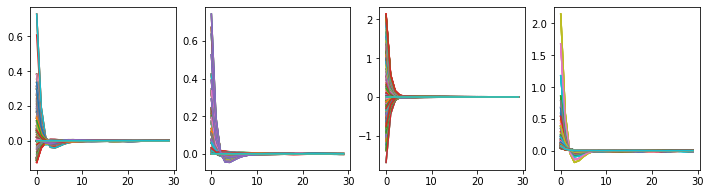

t=2, Num. agents: Pros: 5 tEVs: 5 cEVs: 5
Completed (16.9087 [sec]).
Max. abs. res. d_up/q_up: 0.0024, d_dw/q_dw: 0.0061, u/w: 0.0108, p/q: 0.0109.



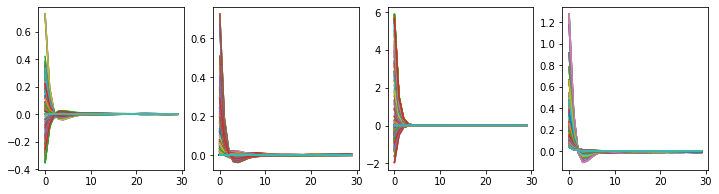

t=3, Num. agents: Pros: 5 tEVs: 5 cEVs: 6
Completed (17.2200 [sec]).
Max. abs. res. d_up/q_up: 0.0024, d_dw/q_dw: 0.0034, u/w: 0.0150, p/q: 0.0109.



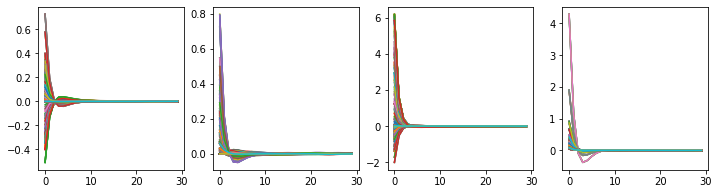

t=4, Num. agents: Pros: 5 tEVs: 5 cEVs: 7
Completed (18.5341 [sec]).
Max. abs. res. d_up/q_up: 0.0019, d_dw/q_dw: 0.0049, u/w: 0.0177, p/q: 0.0109.



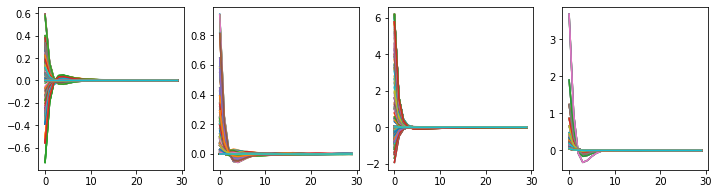

t=5, Num. agents: Pros: 5 tEVs: 5 cEVs: 8
Completed (21.7820 [sec]).
Max. abs. res. d_up/q_up: 0.0027, d_dw/q_dw: 0.0049, u/w: 0.0195, p/q: 0.0104.



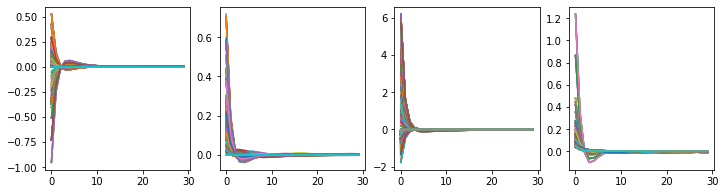

t=6, Num. agents: Pros: 5 tEVs: 7 cEVs: 8
Completed (22.7584 [sec]).
Max. abs. res. d_up/q_up: 0.0025, d_dw/q_dw: 0.0031, u/w: 0.0196, p/q: 0.0105.



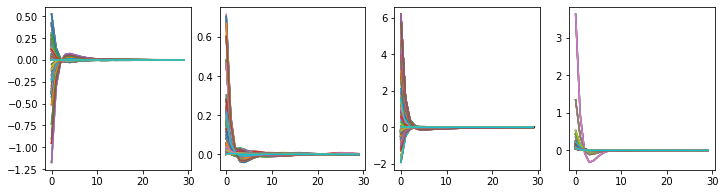

t=7, Num. agents: Pros: 5 tEVs: 7 cEVs: 9


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (23.7590 [sec]).
Max. abs. res. d_up/q_up: 0.0032, d_dw/q_dw: 0.0043, u/w: 0.0198, p/q: 0.0113.



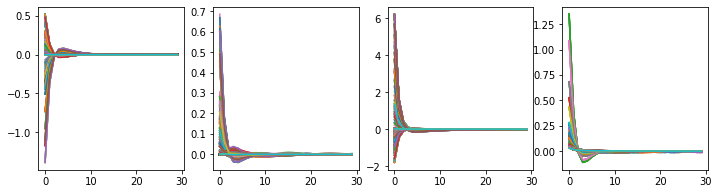

t=8, Num. agents: Pros: 5 tEVs: 7 cEVs: 9
Completed (23.2770 [sec]).
Max. abs. res. d_up/q_up: 0.0026, d_dw/q_dw: 0.0029, u/w: 0.0204, p/q: 0.0104.



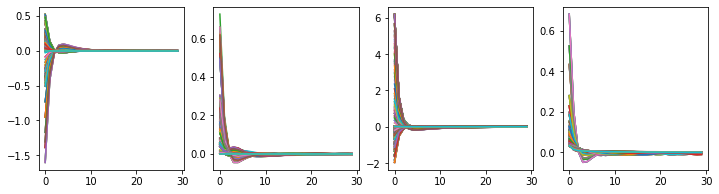

t=9, Num. agents: Pros: 5 tEVs: 7 cEVs: 9
Completed (22.8260 [sec]).
Max. abs. res. d_up/q_up: 0.0028, d_dw/q_dw: 0.0046, u/w: 0.0215, p/q: 0.0113.



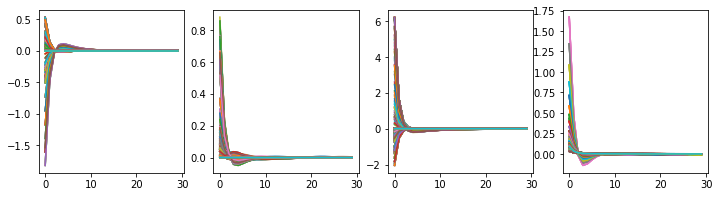

t=10, Num. agents: Pros: 5 tEVs: 7 cEVs: 9
Completed (23.6029 [sec]).
Max. abs. res. d_up/q_up: 0.0048, d_dw/q_dw: 0.0042, u/w: 0.0212, p/q: 0.0108.



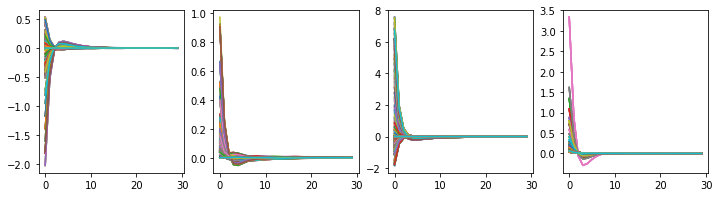

t=11, Num. agents: Pros: 5 tEVs: 7 cEVs: 10
Completed (23.8610 [sec]).
Max. abs. res. d_up/q_up: 0.0030, d_dw/q_dw: 0.0026, u/w: 0.0216, p/q: 0.0108.



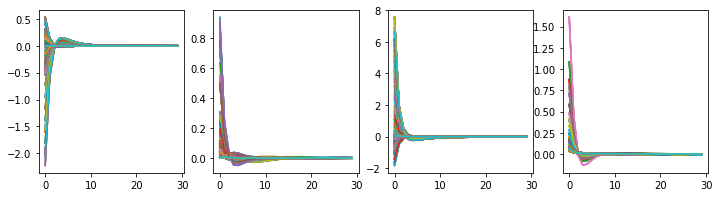

t=12, Num. agents: Pros: 5 tEVs: 7 cEVs: 10
Completed (23.5130 [sec]).
Max. abs. res. d_up/q_up: 0.0047, d_dw/q_dw: 0.0075, u/w: 0.0223, p/q: 0.0104.



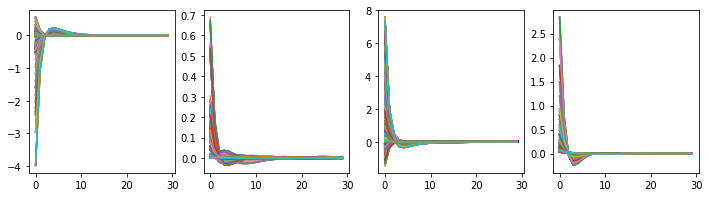

t=13, Num. agents: Pros: 5 tEVs: 7 cEVs: 11
Completed (23.5910 [sec]).
Max. abs. res. d_up/q_up: 0.0027, d_dw/q_dw: 0.0031, u/w: 0.0214, p/q: 0.0100.



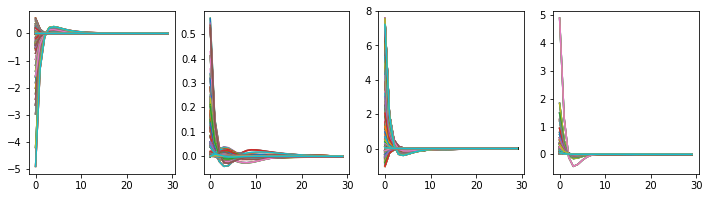

t=14, Num. agents: Pros: 5 tEVs: 7 cEVs: 12
Completed (27.4231 [sec]).
Max. abs. res. d_up/q_up: 0.0111, d_dw/q_dw: 0.0109, u/w: 0.0268, p/q: 0.0106.



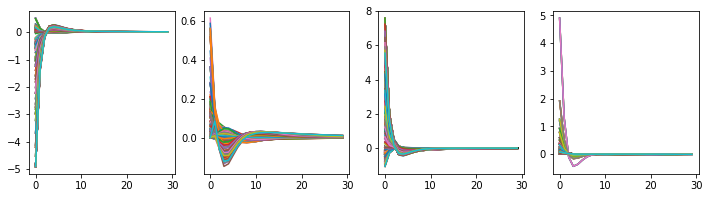

t=15, Num. agents: Pros: 5 tEVs: 8 cEVs: 13
Completed (26.1590 [sec]).
Max. abs. res. d_up/q_up: 0.0123, d_dw/q_dw: 0.0121, u/w: 0.0278, p/q: 0.0057.



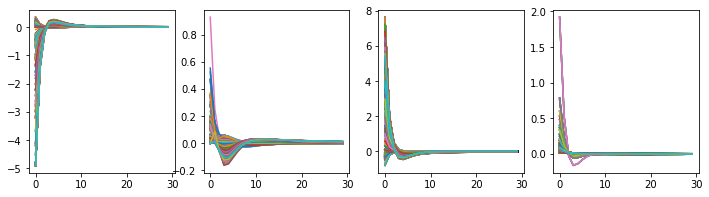

t=16, Num. agents: Pros: 5 tEVs: 8 cEVs: 12
Completed (25.6930 [sec]).
Max. abs. res. d_up/q_up: 0.0125, d_dw/q_dw: 0.0123, u/w: 0.0296, p/q: 0.0057.



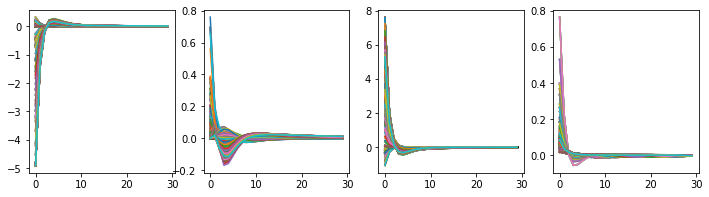

t=17, Num. agents: Pros: 5 tEVs: 8 cEVs: 12
Completed (25.6120 [sec]).
Max. abs. res. d_up/q_up: 0.0131, d_dw/q_dw: 0.0128, u/w: 0.0322, p/q: 0.0057.



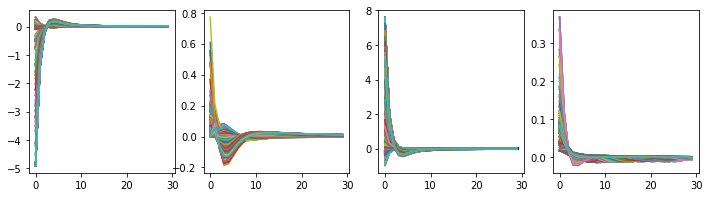

t=18, Num. agents: Pros: 5 tEVs: 8 cEVs: 9
Completed (23.8740 [sec]).
Max. abs. res. d_up/q_up: 0.0131, d_dw/q_dw: 0.0128, u/w: 0.0342, p/q: 0.0057.



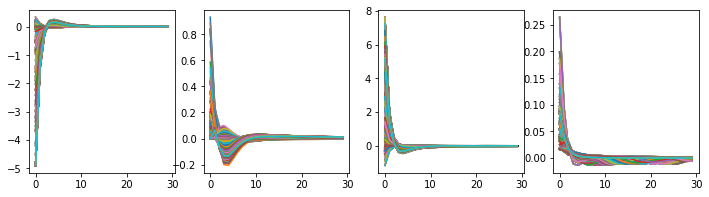

t=19, Num. agents: Pros: 5 tEVs: 8 cEVs: 8
Completed (23.7760 [sec]).
Max. abs. res. d_up/q_up: 0.0131, d_dw/q_dw: 0.0129, u/w: 0.0339, p/q: 0.0056.



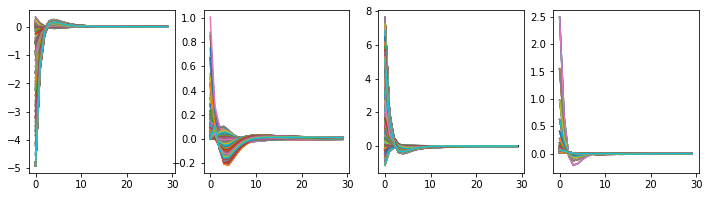

t=20, Num. agents: Pros: 5 tEVs: 8 cEVs: 8
Completed (24.2100 [sec]).
Max. abs. res. d_up/q_up: 0.0131, d_dw/q_dw: 0.0129, u/w: 0.0319, p/q: 0.0048.



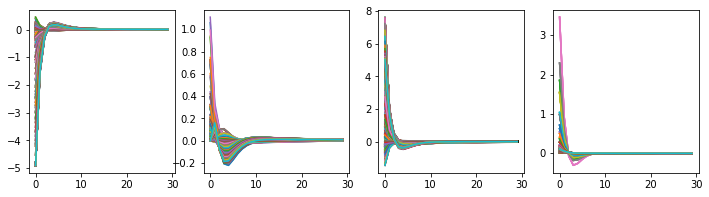

t=21, Num. agents: Pros: 5 tEVs: 8 cEVs: 7
Completed (22.9300 [sec]).
Max. abs. res. d_up/q_up: 0.0131, d_dw/q_dw: 0.0129, u/w: 0.0290, p/q: 0.0060.



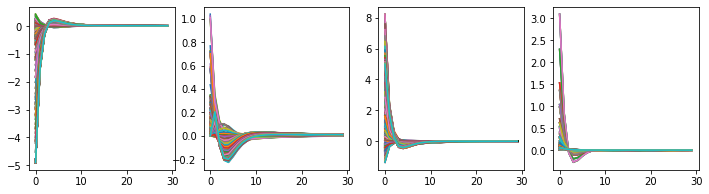

t=22, Num. agents: Pros: 5 tEVs: 8 cEVs: 8
Completed (24.6040 [sec]).
Max. abs. res. d_up/q_up: 0.0131, d_dw/q_dw: 0.0129, u/w: 0.0283, p/q: 0.0056.



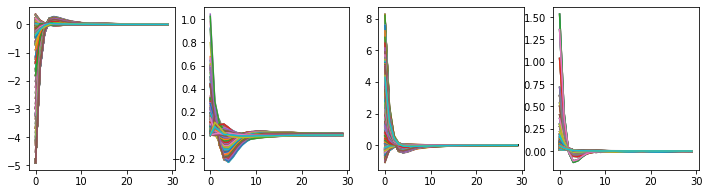

t=23, Num. agents: Pros: 5 tEVs: 9 cEVs: 8
Completed (25.7850 [sec]).
Max. abs. res. d_up/q_up: 0.0131, d_dw/q_dw: 0.0129, u/w: 0.0285, p/q: 0.0113.



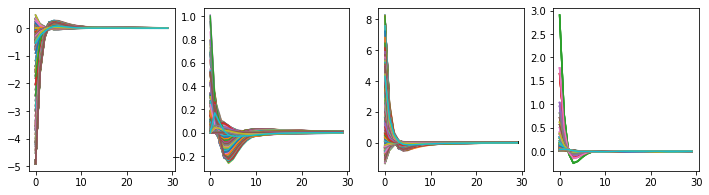

t=24, Num. agents: Pros: 5 tEVs: 9 cEVs: 9
Completed (27.5830 [sec]).
Max. abs. res. d_up/q_up: 0.0132, d_dw/q_dw: 0.0129, u/w: 0.0292, p/q: 0.0114.



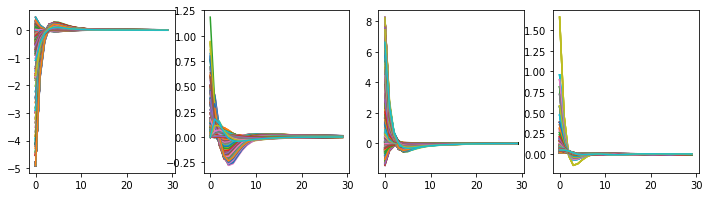

t=25, Num. agents: Pros: 5 tEVs: 10 cEVs: 10
Completed (27.4810 [sec]).
Max. abs. res. d_up/q_up: 0.0132, d_dw/q_dw: 0.0129, u/w: 0.0283, p/q: 0.0115.



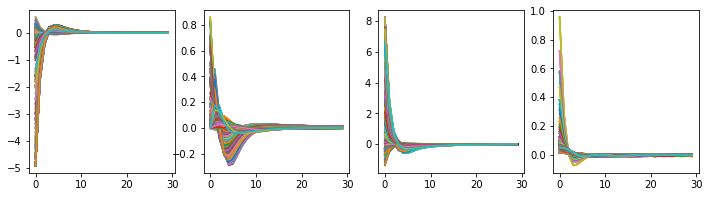

t=26, Num. agents: Pros: 5 tEVs: 10 cEVs: 10
Completed (28.1855 [sec]).
Max. abs. res. d_up/q_up: 0.0132, d_dw/q_dw: 0.0129, u/w: 0.0263, p/q: 0.0111.



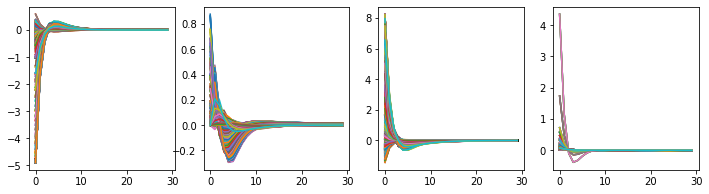

t=27, Num. agents: Pros: 5 tEVs: 10 cEVs: 9
Completed (28.7813 [sec]).
Max. abs. res. d_up/q_up: 0.0135, d_dw/q_dw: 0.0132, u/w: 0.0262, p/q: 0.0113.



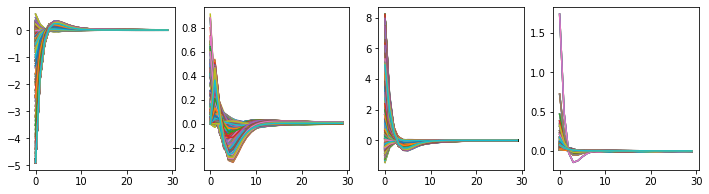

t=28, Num. agents: Pros: 5 tEVs: 11 cEVs: 8
Completed (31.4247 [sec]).
Max. abs. res. d_up/q_up: 0.0136, d_dw/q_dw: 0.0134, u/w: 0.0300, p/q: 0.0108.



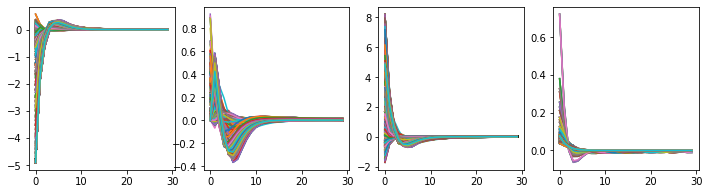

t=29, Num. agents: Pros: 5 tEVs: 11 cEVs: 8
Completed (28.8530 [sec]).
Max. abs. res. d_up/q_up: 0.0134, d_dw/q_dw: 0.0132, u/w: 0.0304, p/q: 0.0079.



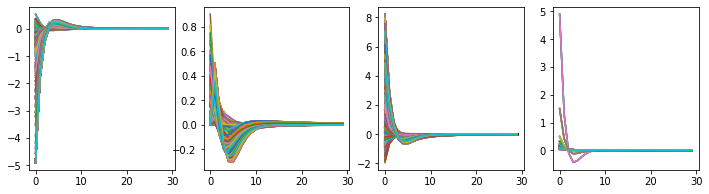

t=30, Num. agents: Pros: 5 tEVs: 11 cEVs: 8


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (28.1300 [sec]).
Max. abs. res. d_up/q_up: 0.0134, d_dw/q_dw: 0.0132, u/w: 0.0313, p/q: 0.0065.



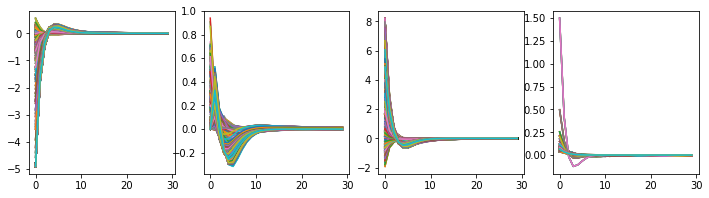

t=31, Num. agents: Pros: 5 tEVs: 10 cEVs: 8
Completed (26.4981 [sec]).
Max. abs. res. d_up/q_up: 0.0133, d_dw/q_dw: 0.0130, u/w: 0.0292, p/q: 0.0061.



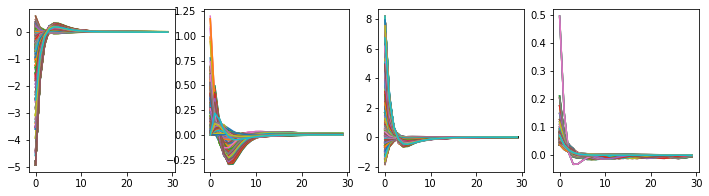

t=32, Num. agents: Pros: 5 tEVs: 10 cEVs: 8


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (28.9260 [sec]).
Max. abs. res. d_up/q_up: 0.0133, d_dw/q_dw: 0.0131, u/w: 0.0249, p/q: 0.0078.



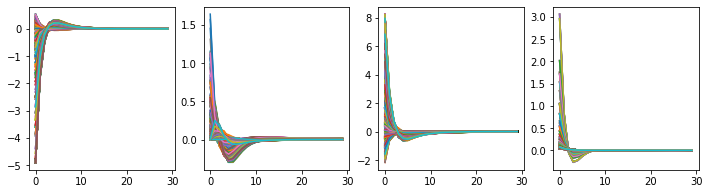

t=33, Num. agents: Pros: 5 tEVs: 10 cEVs: 10


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (29.5690 [sec]).
Max. abs. res. d_up/q_up: 0.0134, d_dw/q_dw: 0.0131, u/w: 0.0247, p/q: 0.0085.



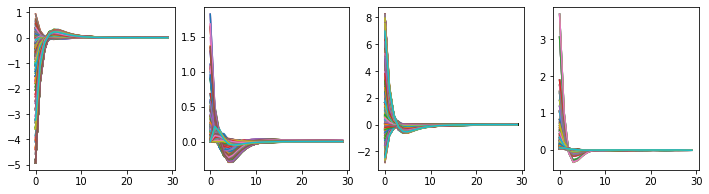

t=34, Num. agents: Pros: 5 tEVs: 9 cEVs: 11
Completed (29.1230 [sec]).
Max. abs. res. d_up/q_up: 0.0133, d_dw/q_dw: 0.0131, u/w: 0.0259, p/q: 0.0095.



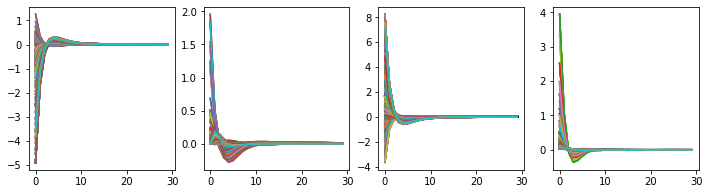

t=35, Num. agents: Pros: 5 tEVs: 9 cEVs: 15
Completed (29.5940 [sec]).
Max. abs. res. d_up/q_up: 0.0134, d_dw/q_dw: 0.0131, u/w: 0.0269, p/q: 0.0096.



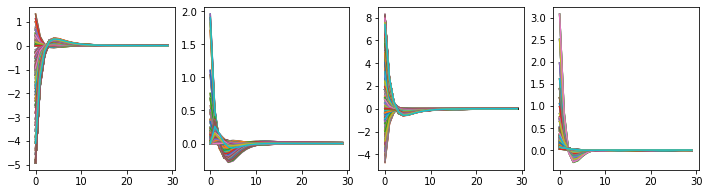

t=36, Num. agents: Pros: 5 tEVs: 9 cEVs: 16


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (29.5110 [sec]).
Max. abs. res. d_up/q_up: 0.0134, d_dw/q_dw: 0.0131, u/w: 0.0277, p/q: 0.0095.



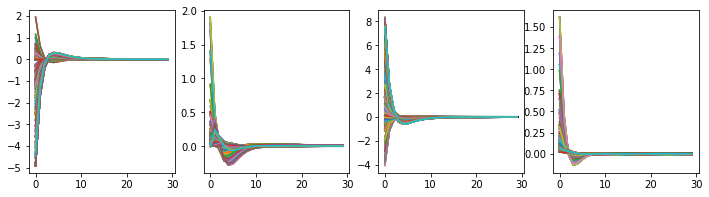

t=37, Num. agents: Pros: 5 tEVs: 9 cEVs: 15


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (29.6876 [sec]).
Max. abs. res. d_up/q_up: 0.0134, d_dw/q_dw: 0.0131, u/w: 0.0288, p/q: 0.0097.



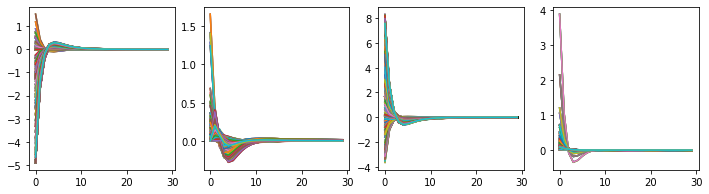

t=38, Num. agents: Pros: 5 tEVs: 9 cEVs: 15
Completed (32.2720 [sec]).
Max. abs. res. d_up/q_up: 0.0133, d_dw/q_dw: 0.0131, u/w: 0.0301, p/q: 0.0109.



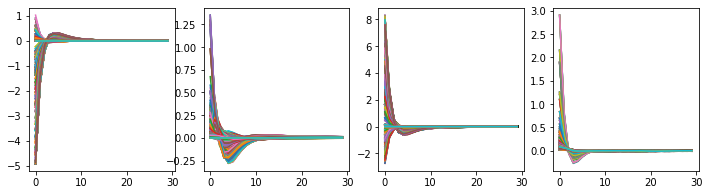

t=39, Num. agents: Pros: 5 tEVs: 10 cEVs: 17
Completed (36.5090 [sec]).
Max. abs. res. d_up/q_up: 0.0143, d_dw/q_dw: 0.0131, u/w: 0.0312, p/q: 0.0124.



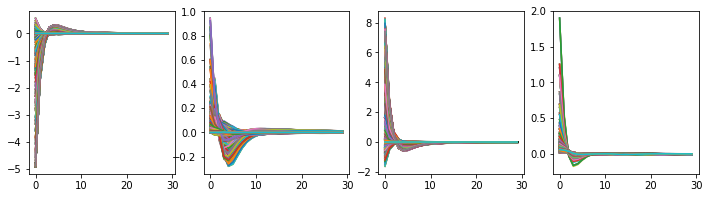

t=40, Num. agents: Pros: 5 tEVs: 12 cEVs: 18
Completed (40.5180 [sec]).
Max. abs. res. d_up/q_up: 0.0146, d_dw/q_dw: 0.0131, u/w: 0.0253, p/q: 0.0091.



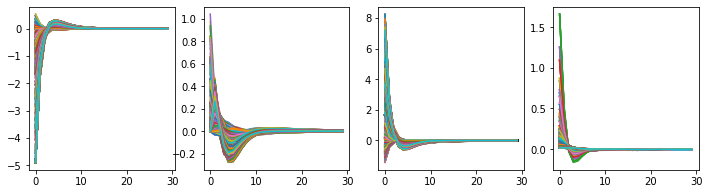

t=41, Num. agents: Pros: 5 tEVs: 14 cEVs: 20
Completed (43.2420 [sec]).
Max. abs. res. d_up/q_up: 0.0148, d_dw/q_dw: 0.0131, u/w: 0.0262, p/q: 0.0102.



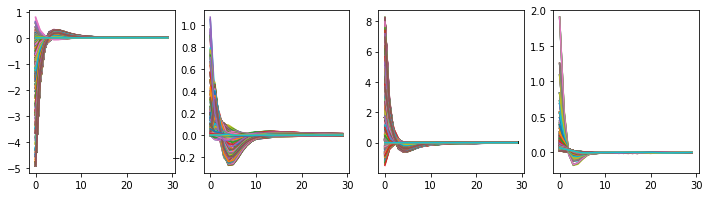

t=42, Num. agents: Pros: 5 tEVs: 14 cEVs: 20
Completed (40.0320 [sec]).
Max. abs. res. d_up/q_up: 0.0151, d_dw/q_dw: 0.0131, u/w: 0.0261, p/q: 0.0107.



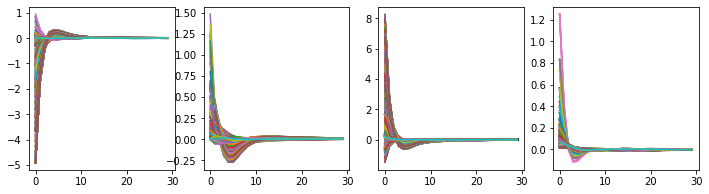

t=43, Num. agents: Pros: 5 tEVs: 13 cEVs: 20
Completed (38.5190 [sec]).
Max. abs. res. d_up/q_up: 0.0133, d_dw/q_dw: 0.0130, u/w: 0.0258, p/q: 0.0104.



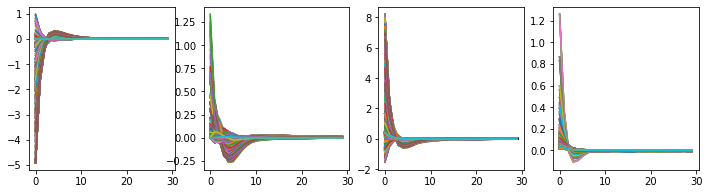

t=44, Num. agents: Pros: 5 tEVs: 12 cEVs: 19
Completed (38.7900 [sec]).
Max. abs. res. d_up/q_up: 0.0137, d_dw/q_dw: 0.0130, u/w: 0.0256, p/q: 0.0092.



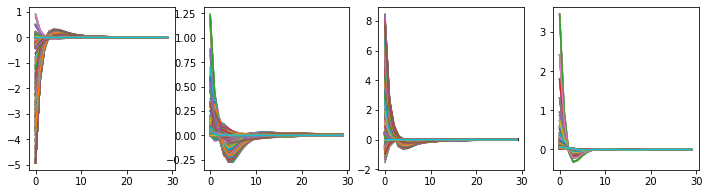

t=45, Num. agents: Pros: 5 tEVs: 13 cEVs: 21
Completed (39.2440 [sec]).
Max. abs. res. d_up/q_up: 0.0137, d_dw/q_dw: 0.0130, u/w: 0.0326, p/q: 0.0094.



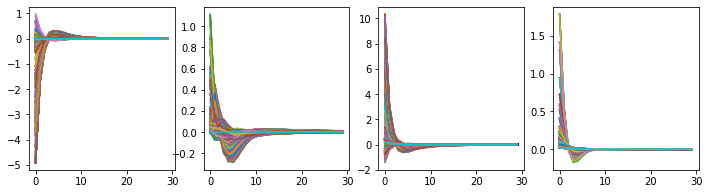

t=46, Num. agents: Pros: 5 tEVs: 13 cEVs: 21


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (41.3440 [sec]).
Max. abs. res. d_up/q_up: 0.0138, d_dw/q_dw: 0.0130, u/w: 0.0332, p/q: 0.0103.



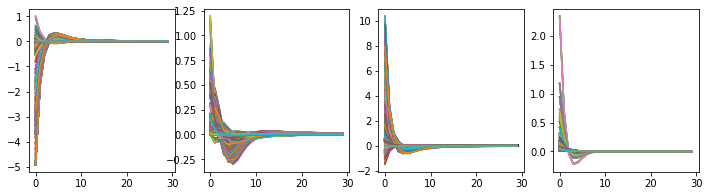

t=47, Num. agents: Pros: 5 tEVs: 14 cEVs: 22
Completed (41.3450 [sec]).
Max. abs. res. d_up/q_up: 0.0133, d_dw/q_dw: 0.0130, u/w: 0.0343, p/q: 0.0112.



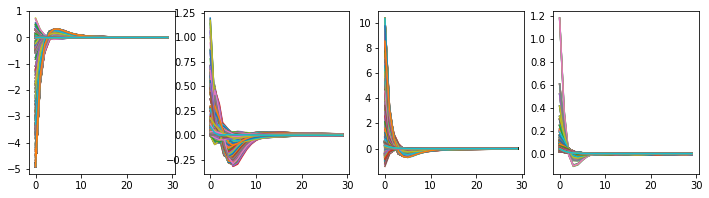

t=48, Num. agents: Pros: 5 tEVs: 12 cEVs: 20
Completed (39.9440 [sec]).
Max. abs. res. d_up/q_up: 0.0119, d_dw/q_dw: 0.0116, u/w: 0.0337, p/q: 0.0065.



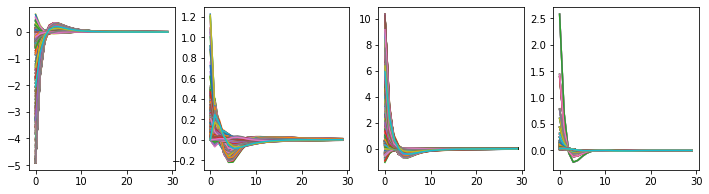

t=49, Num. agents: Pros: 5 tEVs: 13 cEVs: 18
Completed (38.7370 [sec]).
Max. abs. res. d_up/q_up: 0.0126, d_dw/q_dw: 0.0123, u/w: 0.0332, p/q: 0.0089.



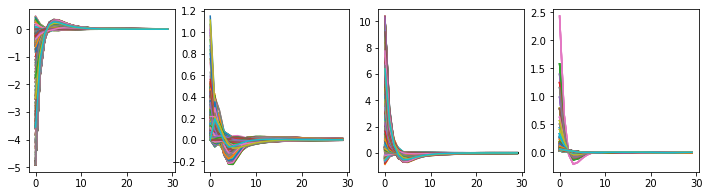

t=50, Num. agents: Pros: 5 tEVs: 11 cEVs: 16
Completed (32.6830 [sec]).
Max. abs. res. d_up/q_up: 0.0130, d_dw/q_dw: 0.0127, u/w: 0.0281, p/q: 0.0064.



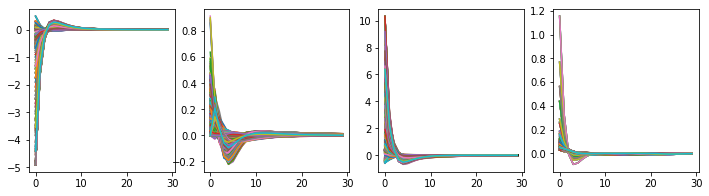

t=51, Num. agents: Pros: 5 tEVs: 11 cEVs: 16
Completed (32.7316 [sec]).
Max. abs. res. d_up/q_up: 0.0133, d_dw/q_dw: 0.0130, u/w: 0.0377, p/q: 0.0065.



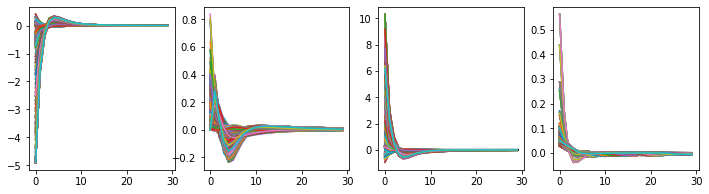

t=52, Num. agents: Pros: 5 tEVs: 10 cEVs: 15
Completed (30.4610 [sec]).
Max. abs. res. d_up/q_up: 0.0133, d_dw/q_dw: 0.0130, u/w: 0.0348, p/q: 0.0054.



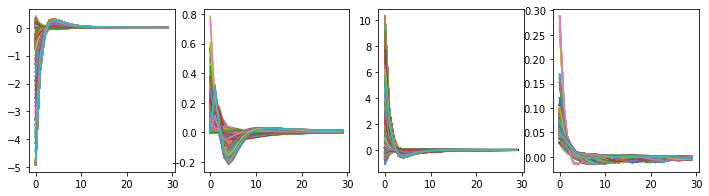

t=53, Num. agents: Pros: 5 tEVs: 10 cEVs: 14
Completed (32.1840 [sec]).
Max. abs. res. d_up/q_up: 0.0134, d_dw/q_dw: 0.0131, u/w: 0.0360, p/q: 0.0122.



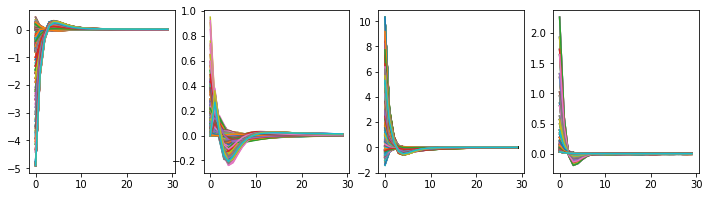

t=54, Num. agents: Pros: 5 tEVs: 10 cEVs: 16
Completed (33.3920 [sec]).
Max. abs. res. d_up/q_up: 0.0135, d_dw/q_dw: 0.0132, u/w: 0.0375, p/q: 0.0128.



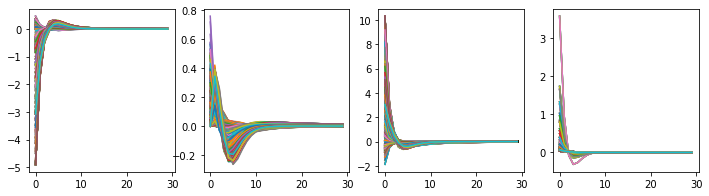

t=55, Num. agents: Pros: 5 tEVs: 11 cEVs: 14
Completed (31.6780 [sec]).
Max. abs. res. d_up/q_up: 0.0135, d_dw/q_dw: 0.0132, u/w: 0.0375, p/q: 0.0073.



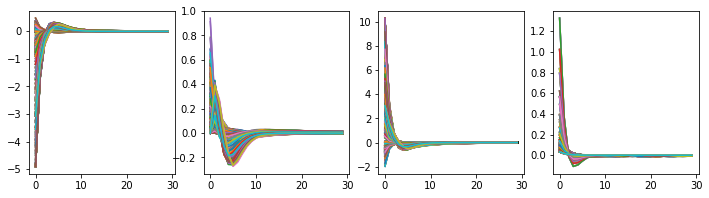

t=56, Num. agents: Pros: 5 tEVs: 11 cEVs: 13
Completed (30.9590 [sec]).
Max. abs. res. d_up/q_up: 0.0135, d_dw/q_dw: 0.0132, u/w: 0.0379, p/q: 0.0103.



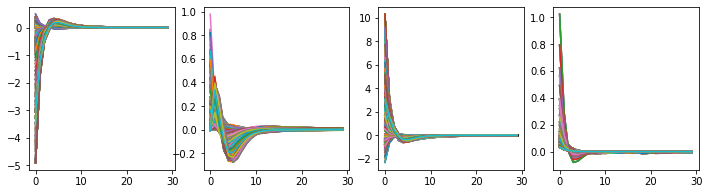

t=57, Num. agents: Pros: 5 tEVs: 11 cEVs: 13


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (33.7990 [sec]).
Max. abs. res. d_up/q_up: 0.0135, d_dw/q_dw: 0.0132, u/w: 0.0380, p/q: 0.0103.



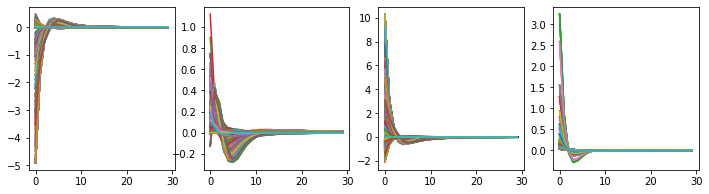

t=58, Num. agents: Pros: 5 tEVs: 12 cEVs: 15


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (37.2090 [sec]).
Max. abs. res. d_up/q_up: 0.0135, d_dw/q_dw: 0.0132, u/w: 0.0383, p/q: 0.0103.



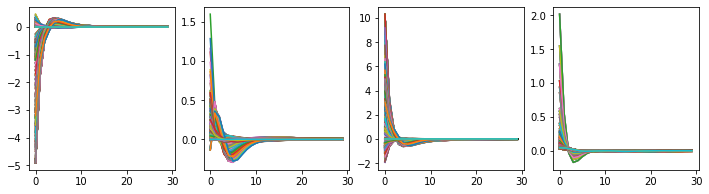

t=59, Num. agents: Pros: 5 tEVs: 13 cEVs: 16


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (37.2590 [sec]).
Max. abs. res. d_up/q_up: 0.0135, d_dw/q_dw: 0.0132, u/w: 0.0388, p/q: 0.0104.



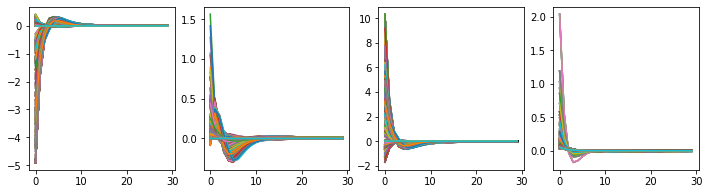

t=60, Num. agents: Pros: 5 tEVs: 13 cEVs: 16


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (36.5180 [sec]).
Max. abs. res. d_up/q_up: 0.0135, d_dw/q_dw: 0.0132, u/w: 0.0395, p/q: 0.0106.



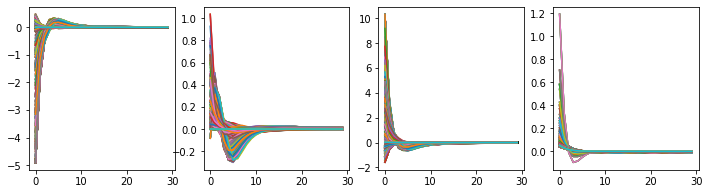

t=61, Num. agents: Pros: 5 tEVs: 13 cEVs: 15


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (38.7820 [sec]).
Max. abs. res. d_up/q_up: 0.0135, d_dw/q_dw: 0.0132, u/w: 0.0395, p/q: 0.0110.



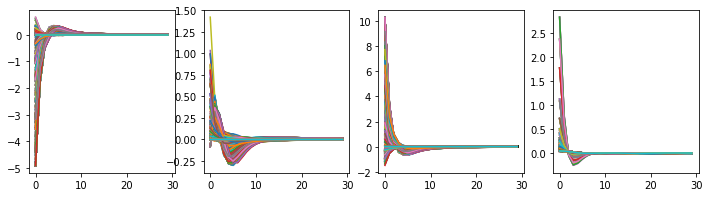

t=62, Num. agents: Pros: 5 tEVs: 14 cEVs: 16


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (40.1721 [sec]).
Max. abs. res. d_up/q_up: 0.0135, d_dw/q_dw: 0.0132, u/w: 0.0389, p/q: 0.0093.



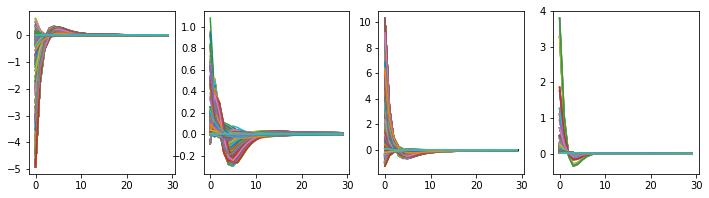

t=63, Num. agents: Pros: 5 tEVs: 14 cEVs: 16


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (37.8020 [sec]).
Max. abs. res. d_up/q_up: 0.0135, d_dw/q_dw: 0.0132, u/w: 0.0399, p/q: 0.0103.



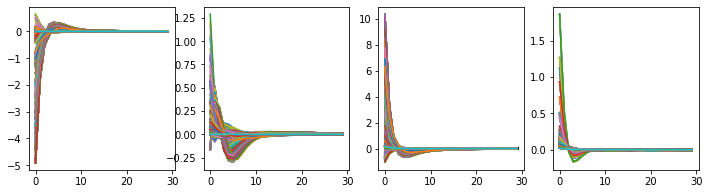

t=64, Num. agents: Pros: 5 tEVs: 12 cEVs: 14


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (33.9410 [sec]).
Max. abs. res. d_up/q_up: 0.0133, d_dw/q_dw: 0.0130, u/w: 0.0390, p/q: 0.0090.



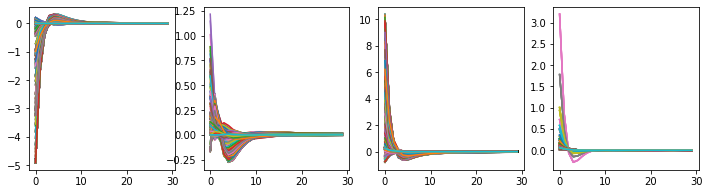

t=65, Num. agents: Pros: 5 tEVs: 11 cEVs: 13


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (36.4110 [sec]).
Max. abs. res. d_up/q_up: 0.0134, d_dw/q_dw: 0.0129, u/w: 0.0369, p/q: 0.0101.



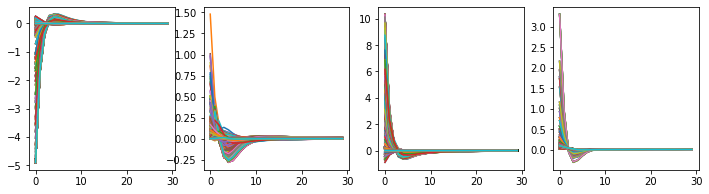

t=66, Num. agents: Pros: 5 tEVs: 13 cEVs: 14


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (37.3860 [sec]).
Max. abs. res. d_up/q_up: 0.0132, d_dw/q_dw: 0.0130, u/w: 0.0381, p/q: 0.0095.



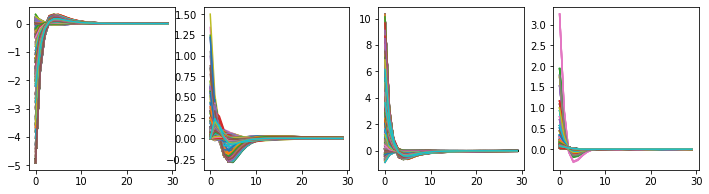

t=67, Num. agents: Pros: 5 tEVs: 13 cEVs: 15


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (39.9720 [sec]).
Max. abs. res. d_up/q_up: 0.0130, d_dw/q_dw: 0.0128, u/w: 0.0389, p/q: 0.0089.



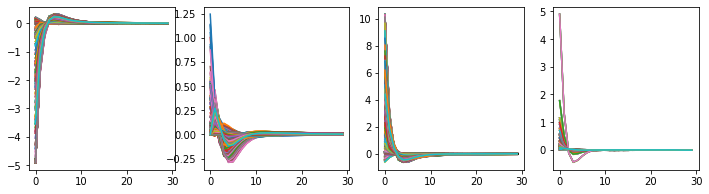

t=68, Num. agents: Pros: 5 tEVs: 15 cEVs: 16
Completed (40.3990 [sec]).
Max. abs. res. d_up/q_up: 0.0130, d_dw/q_dw: 0.0128, u/w: 0.0398, p/q: 0.0091.



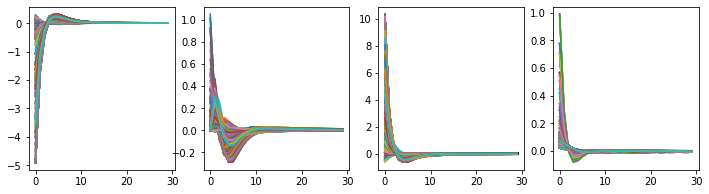

t=69, Num. agents: Pros: 5 tEVs: 15 cEVs: 14


C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Completed (41.4370 [sec]).
Max. abs. res. d_up/q_up: 0.0131, d_dw/q_dw: 0.0128, u/w: 0.0420, p/q: 0.0095.



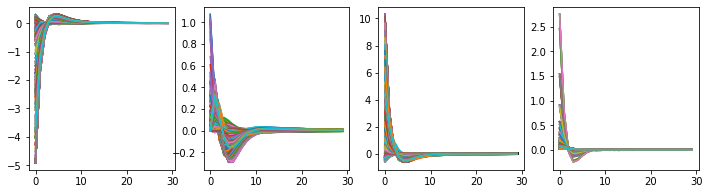

t=70, Num. agents: Pros: 5 tEVs: 15 cEVs: 13
Completed (39.5900 [sec]).
Max. abs. res. d_up/q_up: 0.0131, d_dw/q_dw: 0.0139, u/w: 0.0441, p/q: 0.0103.



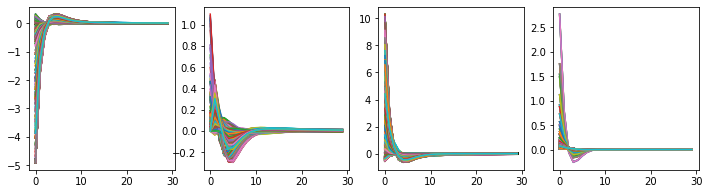

t=71, Num. agents: Pros: 5 tEVs: 15 cEVs: 12
Completed (38.4950 [sec]).
Max. abs. res. d_up/q_up: 0.0131, d_dw/q_dw: 0.0130, u/w: 0.0429, p/q: 0.0108.



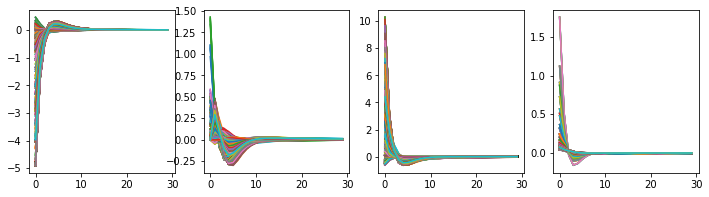

t=72, Num. agents: Pros: 5 tEVs: 14 cEVs: 12
Completed (37.2310 [sec]).
Max. abs. res. d_up/q_up: 0.0109, d_dw/q_dw: 0.0107, u/w: 0.0425, p/q: 0.0099.



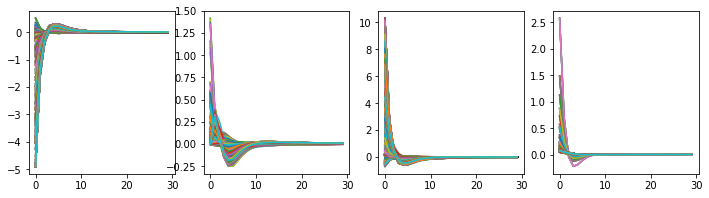

In [10]:
''' 
MPC SYSTEM
'''

# Create the sets of agents
Data.pros = {(ID := next(new_id)): Prosumer(ID) for _ in range(INIT_PROSUMERS)}
Data.tevs = {(ID := next(new_id)): tEV(ID) for _ in range(INIT_TEVS)}
Data.cevs = {(ID := next(new_id)): cEV(ID) for _ in range(INIT_CEVS)}

# MCP starts
while Data.t < 24*T:
    start_time = time.time()
    
    # Update current time 
    Data.clock()
    
    # Check if EVs are still parked/charging
    for tev in list(Data.tevs.values()):
        if not tev.is_active:
            Data.departed_evs[tev.ID] = Data.tevs.pop(tev.ID)
        
    for cev in list(Data.cevs.values()):
        if not cev.is_active:
            Data.departed_evs[cev.ID] = Data.cevs.pop(cev.ID)
    
    print(f"t={Data.t}, Num. agents: Pros: {Data.P()} tEVs: {Data.S()} cEVs: {Data.C()}")
    
    # Add newly arrived EVs
    Data.tevs.update({(ID := next(new_id)): tEV(ID) for _ in range(num_new_evs(AVG_NUM_NEW_TEVS))})
    Data.cevs.update({(ID := next(new_id)): cEV(ID) for _ in range(num_new_evs(AVG_NUM_NEW_CEVS))})
    
    # Start ADALM
    vrs = DotDict()
    vrs.a_up = np.zeros([Data.P(), H])
    vrs.a_dw = np.zeros([Data.P(), H])
    vrs.d_up = np.zeros([Data.P(), Data.S(), H])
    vrs.d_dw = np.zeros([Data.P(), Data.S(), H])
    vrs.u    = np.zeros([Data.P(), Data.S(), H])
    vrs.p    = np.zeros([Data.P(), Data.C(), H])

    vrs.b_up = np.zeros([Data.P(), Data.S(), H])
    vrs.b_dw = np.zeros([Data.P(), Data.S(), H])
    vrs.w    = np.zeros([Data.P(), Data.S(), H])
    
    vrs.r = np.zeros([Data.C(), H])
    vrs.q = np.zeros([Data.P(), Data.C(), H])
    
    mlt = DotDict()
    mlt.phi_up = np.zeros([Data.P(), Data.S(), H])
    mlt.phi_dw = np.zeros([Data.P(), Data.S(), H])
    mlt.theta  = np.zeros([Data.P(), Data.S(), H])
    mlt.psi    = np.zeros([Data.P(), Data.C(), H])
    
    res = DotDict()
    res.db_up = np.zeros([Data.P(), Data.S(), H, ITERS])
    res.db_dw = np.zeros([Data.P(), Data.S(), H, ITERS])
    res.uw    = np.zeros([Data.P(), Data.S(), H, ITERS])
    res.pq    = np.zeros([Data.P(), Data.C(), H, ITERS])
    
    # Create optimization problem 
    for agent in (Data.pros | Data.tevs | Data.cevs).values():
        agent.create_problem()
        
    RHO_S, RHO_C = 0, 0
    
    for ITR in range(ITERS):
        # Solve optimization problems
        for pro in Data.pros.values():
            pro.update_and_solve(vrs, mlt)

            vrs.a_up[pro.idx,:]   += CHI*(np.squeeze(pro.a_up.value) - vrs.a_up[pro.idx,:])
            vrs.a_dw[pro.idx,:]   += CHI*(np.squeeze(pro.a_dw.value) - vrs.a_dw[pro.idx,:])
            vrs.d_up[pro.idx,:,:] += CHI*(pro.d_up.value - np.squeeze(vrs.d_up[pro.idx,:,:]))
            vrs.d_dw[pro.idx,:,:] += CHI*(pro.d_dw.value - np.squeeze(vrs.d_dw[pro.idx,:,:]))
            vrs.u[pro.idx,:,:]    += CHI*(pro.u.value - np.squeeze(vrs.u[pro.idx,:,:]))
            vrs.p[pro.idx,:,:]    += CHI*(pro.p.value - np.squeeze(vrs.p[pro.idx,:,:]))
            
        for tev in Data.tevs.values():
            tev.update_and_solve(vrs, mlt)
            
            vrs.b_up[:,tev.idx,:] += CHI*(tev.b_up.value - np.squeeze(vrs.b_up[:,tev.idx,:]))
            vrs.b_dw[:,tev.idx,:] += CHI*(tev.b_dw.value - np.squeeze(vrs.b_dw[:,tev.idx,:]))
            vrs.w[:,tev.idx,:]    += CHI*(tev.w.value - np.squeeze(vrs.w[:,tev.idx,:]))            
            
        for cev in Data.cevs.values():
            cev.update_and_solve(vrs, mlt)
            
            vrs.r[cev.idx,:]   += CHI*(np.squeeze(cev.r.value) - vrs.r[cev.idx,:]) 
            vrs.q[:,cev.idx,:] += CHI*(cev.q.value - vrs.q[:,cev.idx,:])
        
        # Update residuals and multipliers
        res.db_up[:,:,:,ITR] = vrs.d_up - vrs.b_up
        res.db_dw[:,:,:,ITR] = vrs.d_dw - vrs.b_dw
        res.uw[:,:,:,ITR]    = vrs.w - vrs.u
        res.pq[:,:,:,ITR]    = vrs.q - vrs.p
        
        mlt.phi_up += CHI*RHO_S*np.squeeze(res.db_up[:,:,:,ITR])
        mlt.phi_dw += CHI*RHO_S*np.squeeze(res.db_dw[:,:,:,ITR])
        mlt.theta  += CHI*RHO_S*np.squeeze(res.uw[:,:,:,ITR])
        mlt.psi    += CHI*RHO_C*np.squeeze(res.pq[:,:,:,ITR])
        
        RHO_S, RHO_C = 1, 15
        
    # Update initial storage
    for pro in Data.pros.values():
        for tev in Data.tevs.values():
            pro.init_u[tev.ID] = pro.u[tev.idx,0].value
            tev.init_w[pro.ID] = tev.w[pro.idx,0].value
            
    # Append to history 
    Data.hist_pros.append({pro.ID: pro.saved() for pro in Data.pros.values()})
    Data.hist_tevs.append({tev.ID: tev.saved() for tev in Data.tevs.values()})
    Data.hist_cevs.append({cev.ID: cev.saved() for cev in Data.cevs.values()})
    Data.hist_departed_evs.append({ev.ID: ev.saved() for ev in Data.departed_evs.values()})
            
    # Summary
    print(f"Completed ({(time.time() - start_time):.4f} [sec]).\n"
          f"Max. abs. res. d_up/q_up: {np.max(np.abs(res.db_up[:,:,:,-1])):.4f}, " 
          f"d_dw/q_dw: {np.max(np.abs(res.db_dw[:,:,:,-1])):.4f}, "
          f"u/w: {np.max(np.abs(res.uw[:,:,:,-1])):.4f}, "
          f"p/q: {np.max(np.abs(res.pq[:,:,:,-1])):.4f}.\n")
    
    # Plot residuals
    fig, axs = plt.subplots(1, 4, figsize=(12,3))
    for idx,re in zip(range(4), res.values()):
        axs[idx].plot(np.arange(ITERS), re.reshape((-1,ITERS)).T)
    plt.show(block=False)

# Save all
timestamp   = datetime.datetime.now().strftime("%b-%a-%Y_%H-%M-%S")
folder_name = FILEPATH_RES + f"{timestamp}/"

os.mkdir(folder_name)
with open(folder_name + "hist_pros.json", "w") as file:
    json.dump(Data.hist_pros, file)
    
with open(folder_name + "hist_tevs.json", "w") as file:
    json.dump(Data.hist_tevs, file)
    
with open(folder_name + "hist_cevs.json", "w") as file:
    json.dump(Data.hist_cevs, file)
    
with open(folder_name + "hist_departed_evs.json", "w") as file:
    json.dump(Data.hist_departed_evs, file)

# Plots and Figures

In [5]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap

In [8]:
def keys2int(x):
    return {(int(k) if k.isnumeric() else k): v for k, v in x.items()}

# Load residuals (from older simulations)
db_up = np.load(FILEPATH_RES + "residuals/db_up.npy")
db_dw = np.load(FILEPATH_RES + "residuals/db_dw.npy")
uw    = np.load(FILEPATH_RES + "residuals/uw.npy")
pq    = np.load(FILEPATH_RES + "residuals/pq.npy")

# Load data
FILEPATH_DATA = "Jun-Tue-2022_18-11-14/"
#FILEPATH_DATA = ""
if FILEPATH_DATA:
    for group in HIST:
        with open(FILEPATH_RES + FILEPATH_DATA + f"{group}.json", "r") as file:
            setattr(Data, group, json.load(file, object_hook=keys2int))

In [9]:
# Figure settings
FIGSIZE_TWO_COL_WIDTH = 8
FIGSIZE_COL_WIDTH     = 3.5

# Colors
PROS_COL = "#41D15F"
TEVS_COL = "#4B53FF"
CEVS_COL = "#4BBEFF"
RET_COL  = "#FF0000"
NEUTRAL  = "#333333"

latex_preamble = [
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}',
    r'\usepackage{amsmath}',
]

cm = 1/2.54
plt.rcParams.update({
    "grid.alpha": 0.5,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "legend.frameon": False,
    "ytick.labelsize": 8,
    "xtick.labelsize": 8,
    "font.size": 9,
    "font.family": "sans",
    "font.sans-serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "text.latex.preamble": "".join(latex_preamble)
})

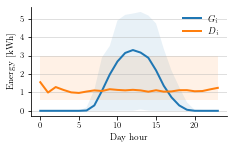

In [10]:
# Plot generation and demand
fig = plt.figure(figsize=(FIGSIZE_COL_WIDTH,2))
ax  = plt.axes()

# Generation and demand aggregate data
avg_generation, avg_demand = np.mean(GENERATION, 0), np.mean(DEMAND, 0)
min_generation, min_demand = np.min(GENERATION, 0), np.min(DEMAND, 0)
max_generation, max_demand = np.max(GENERATION, 0), np.max(DEMAND, 0)

# Plot 
plt.plot(avg_generation, label="$G_i$", linewidth=2); plt.plot(avg_demand, label="$D_i$", linewidth=2)
plt.fill_between(np.arange(24), min_generation, max_generation, alpha=0.1)
plt.fill_between(np.arange(24), min_demand, max_demand, alpha=0.1)

ax.set_xlabel("Day hour")
ax.set_ylabel("Energy [kWh]")
plt.grid(zorder=0, axis="y")
ax.legend()

plt.savefig(FILEPATH_FIG + "generation_demand.pdf", bbox_inches='tight')
plt.show(block=False)

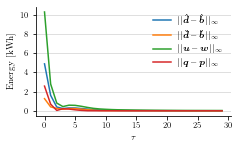

In [11]:
# Plot residuals
fig = plt.figure(figsize=(FIGSIZE_COL_WIDTH,2))
ax  = plt.axes()

plt.plot(np.linalg.norm(db_up.reshape((-1,ITERS)), np.inf, 0), 
        label=r"$||\boldsymbol{\hat{d}} - \boldsymbol{\hat{b}}||_\infty$")
plt.plot(np.linalg.norm(db_dw.reshape((-1,ITERS)), np.inf, 0),
        label=r"$||\boldsymbol{\check{d}} - \boldsymbol{\check{b}}||_\infty$")
plt.plot(np.linalg.norm(uw.reshape((-1,ITERS)), np.inf, 0),
        label=r"$||\boldsymbol{u} - \boldsymbol{w}||_\infty$")
plt.plot(np.linalg.norm(pq.reshape((-1,ITERS)), np.inf, 0), 
        label=r"$||\boldsymbol{q} - \boldsymbol{p}||_\infty$")

ax.set_xlabel(r"$\tau$")
ax.set_ylabel("Energy [kWh]")
plt.grid(zorder=0, axis="y")
plt.legend()

plt.savefig(FILEPATH_FIG + "convergence.pdf", bbox_inches='tight')
plt.show(block=False)

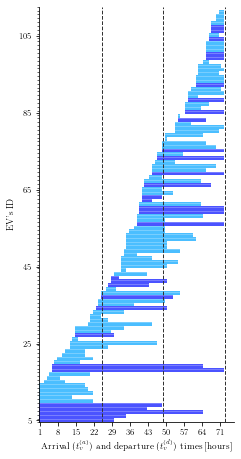

In [12]:
# EVs arrival and departure
EV_STEP = 20
T_STEP  = 7

all_evs  = Data.hist_departed_evs[-1] | Data.hist_cevs[-1] | Data.hist_tevs[-1]
first_ev = min(list(all_evs.keys()))
last_ev  = max(list(all_evs.keys()))
time_table = np.zeros([len(all_evs), 24*T])

for ev in all_evs.values():
    if "range" in ev:
        value = 2*np.ones(ev["t_curr"]-ev["t_init"])
    else:
        value = np.ones(ev["t_curr"]-ev["t_init"])
    time_table[ev["ID"]-first_ev, ev["t_init"]:ev["t_curr"]] = value
    
# Plot timetable
fig = plt.figure(figsize=(FIGSIZE_COL_WIDTH, FIGSIZE_TWO_COL_WIDTH))
ax  = plt.axes()

# Colormap 
cmap = ListedColormap(["w", TEVS_COL, CEVS_COL])
tran = [0,1,2,3]
norm = BoundaryNorm(tran, cmap.N)

plt.imshow(time_table, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

# Ticks 
ax.set_yticks(np.arange(-.5, time_table.shape[0]), minor=True)
ax.set_yticks(np.arange(0, time_table.shape[0], EV_STEP), 
              labels=[str(t) for t in range(first_ev, last_ev + 1, EV_STEP)])
ax.set_xticks(np.arange(0, time_table.shape[1], T_STEP), 
              labels=[str(t) for t in range(1, 24*T + 1, T_STEP)])

# Seperating days
for day_hour in range(24,24*(T+1),24):
    plt.axvline(day_hour, linestyle="--", linewidth=1, color=NEUTRAL)

# Axis labels and grid
ax.set_aspect(1.5)
ax.set_xlabel("Arrival ($t^{(a)}_v$) and departure ($t^{(d)}_v$) times [hours]")
ax.set_ylabel("EV's ID")
ax.grid(which="minor", axis="y", color="w", linewidth=0.5)

plt.savefig(FILEPATH_FIG + "timetable.pdf", bbox_inches='tight')
plt.show(block=False)

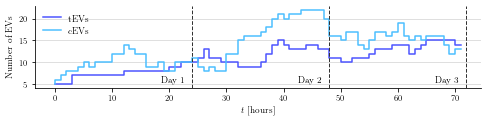

In [13]:
# Number of EVs at each time 
num_tevs = np.array([len(tevs) for tevs in Data.hist_tevs])
num_cevs = np.array([len(cevs) for cevs in Data.hist_cevs])

fig = plt.figure(figsize=(FIGSIZE_TWO_COL_WIDTH, 1.5))
ax = plt.axes()
plt.step(np.arange(24*T), num_tevs, color=TEVS_COL, label="tEVs")
plt.step(np.arange(24*T), num_cevs, color=CEVS_COL, label="cEVs")

# Seperating days
for day_hour in range(24,24*(T+1),24):
    plt.axvline(day_hour, linestyle="--", linewidth=1, color=NEUTRAL)
    plt.text(day_hour - 5.5, 5.5, f"Day {day_hour // 24}")

ax.grid(axis="y")
ax.set_xlabel("$t$ [hours]")
ax.set_ylabel("Number of EVs")
plt.legend()

plt.savefig(FILEPATH_FIG + "num_evs.pdf", bbox_inches='tight')
plt.show(block=False)

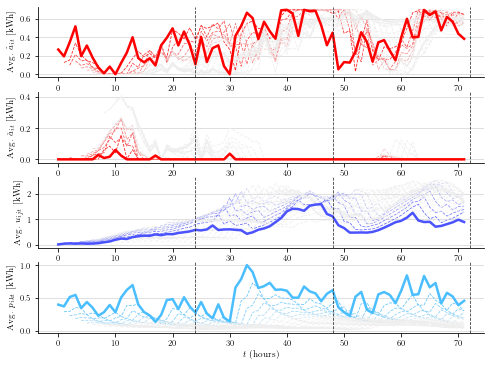

In [34]:
# Plot MPC projections (energy)
CMAP_STEPS = 8
fig, axs = plt.subplots(4,1,figsize=(FIGSIZE_TWO_COL_WIDTH, 6))

FLOWS = (
    (0, "a_up", RET_COL, "\hat{a}_{it}"), 
    (1, "a_dw", RET_COL, "\check{a}_{it}"), 
    (2, "u", TEVS_COL, "u_{ijt}"), 
    (3, "p", CEVS_COL, "p_{ikt}")
)

for i, var, col, lab in FLOWS:
    # Gather agent data
    flow = np.zeros([Data.hist_P(), H, 24*T])
    for t,pros in enumerate(Data.hist_pros):
        for pro in pros.values():
            flow[pro["ID"],:,t] = np.sum(pro[var],0)

    # Average and shifts rows
    avg_flow = np.mean(flow,0)

    # Colormap
    colrange = [col, "#EEEEEE"]
    cmap     = LinearSegmentedColormap.from_list("Custom", colrange, N=CMAP_STEPS)

    for j in range(1,H):
        axs[i].plot(np.arange(j,24*T), avg_flow[j,:24*T-j], linewidth=0.8, color=cmap(min(j,CMAP_STEPS)), linestyle="--")
    axs[i].plot(np.arange(0,24*T), avg_flow[0,:], linewidth=2.5, color=col)

    # Seperating days
    for day_hour in range(24,24*(T+1),24):
        axs[i].axvline(day_hour, linestyle="--", linewidth=0.8, color=NEUTRAL)
        #axs[i].text(day_hour - 4.5, 2.6, f"Day {day_hour // 24}")

    axs[i].grid(axis="y")
    axs[i].set_xlabel("$t$ (hours)")
    axs[i].set_ylabel(f"Avg. ${lab}$ [kWh]")

plt.savefig(FILEPATH_FIG + "mpc_flow.pdf", bbox_inches='tight')
plt.show(block=False)

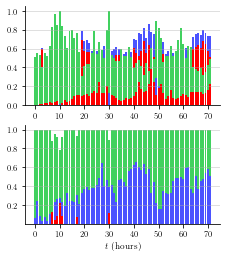

In [37]:
# Energy composition
INFLOW  = ("a_up", "d_dw", "G")
OUTFLOW = ("a_dw", "d_up", "D")

comp = DotDict()
for var in INFLOW + OUTFLOW:
    setattr(comp, var, np.zeros(24*T))
    
for t, pros in enumerate(Data.hist_pros):
    for var in INFLOW + OUTFLOW:
        variable = getattr(comp, var)
        if var == "G" or var == "D":
            variable[t] = np.mean([np.array(pro[var])[t] for pro in pros.values()])
        else:
            variable[t] = np.mean([np.sum(np.array(pro[var]),0)[0] for pro in pros.values()])
        
tot_inflow  = comp["a_up"] + comp["d_dw"] + comp["G"]
tot_outflow = comp["a_dw"] + comp["d_up"] + comp["D"]

# Plot composion
fig, axs = plt.subplots(2,1, figsize=(FIGSIZE_COL_WIDTH, 4))

x = np.arange(24*T)

bottom = 0
axs[0].grid(axis="y", zorder=0)
for var, col in zip(INFLOW, (RET_COL, TEVS_COL, PROS_COL)):
    variable = getattr(comp, var)
    variable /= tot_inflow
    axs[0].bar(x, variable, bottom=bottom, color=col)
    bottom = variable
    
bottom = 0
axs[1].grid(axis="y", zorder=0)
for var, col in zip(OUTFLOW, (RET_COL, TEVS_COL, PROS_COL)):
    variable = getattr(comp, var)
    variable /= tot_outflow
    axs[1].bar(x, variable, bottom=bottom, color=col)
    bottom = variable
    
axs[1].set_xlabel("$t$ (hours)")
plt.show(block=False)

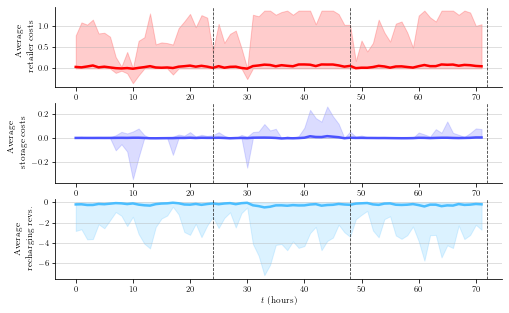

In [39]:
# Plot MPC projections (costs/revenues)
CMAP_STEPS = 8
fig, axs = plt.subplots(3,1,figsize=(FIGSIZE_TWO_COL_WIDTH, 5))

# Retailer costs/revenues
ret_costs   = np.zeros([Data.hist_P(), H, 24*T])
ret_storage = np.zeros([Data.hist_P(), H, 24*T])
ret_cev_chr = np.zeros([Data.hist_P(), H, 24*T])
for t,pros in enumerate(Data.hist_pros):
    for pro in pros.values():
        ret_costs[pro["ID"],:,t]   = np.array(pro["cost_ret"]) - np.array(pro["revs_ret"])
        # ret_storage[pro["ID"],:,t] = np.array(pro["cost_chr"]) + np.array(pro["cost_dis"]) - np.array(pro["refund_tevs"])
        ret_storage[pro["ID"],:,t] = np.array(pro["cost_chr"]) + np.array(pro["cost_dis"]) - np.array(pro["refund_tevs"])
        ret_cev_chr[pro["ID"],:,t] = -np.array(pro["revs_cevs"])
        
# Averaging 
avg_ret_costs   = np.mean(ret_costs,0)
avg_ret_storage = np.mean(ret_storage,0)
avg_ret_cev_chr = np.mean(ret_cev_chr,0)

max_ret_costs   = np.max(ret_costs,0)
max_ret_storage = np.max(ret_storage,0)
max_ret_cev_chr = np.max(ret_cev_chr,0)

min_ret_costs   = np.min(ret_costs,0)
min_ret_storage = np.min(ret_storage,0)
min_ret_cev_chr = np.min(ret_cev_chr,0)

COSTS = (
    (0, avg_ret_costs, max_ret_costs, min_ret_costs, RET_COL, "retailer costs"), 
    (1, avg_ret_storage, max_ret_storage, min_ret_costs, TEVS_COL, "storage costs"), 
    (2, avg_ret_cev_chr, max_ret_cev_chr, min_ret_cev_chr, CEVS_COL, "recharging revs."), 
)

for i, cost, ub, lb, col, lab in COSTS:
    # Colormap
    colrange = [col, "#EEEEEE"]
    cmap     = LinearSegmentedColormap.from_list("Custom", colrange, N=CMAP_STEPS)
#     for j in range(1,H):
#         axs[i].plot(np.arange(j,24*T), cost[j,:24*T-j], linewidth=0.8, 
#                     color=cmap(min(j,CMAP_STEPS)), linestyle="--")
    axs[i].plot(np.arange(24*T), cost[0,:], linewidth=2.5, color=col)
    axs[i].fill_between(np.arange(24*T), lb[0,:], ub[0,:], color=col, alpha=0.2)
    
    # Seperating days
    for day_hour in range(24,24*(T+1),24):
        axs[i].axvline(day_hour, linestyle="--", linewidth=0.8, color=NEUTRAL)
        #axs[i].text(day_hour - 4.5, 2.6, f"Day {day_hour // 24}")
    
    axs[i].grid(axis="y")
    axs[i].set_xlabel("$t$ (hours)")
    axs[i].set_ylabel(f"Average \\\ {lab}")
    
plt.savefig(FILEPATH_FIG + "mpc_cost.pdf", bbox_inches='tight')
plt.show(block=False)